# **RADIOMICS ANALYSIS - Machine Learning**

(*Step 11*)

## **Radiomics Workflow:**
  
  **1. Download** DICOM images and convert to **NRRD.**

  **2.** Perform **target segmentations** and save in **NRRD.**
  
  **3.** Perform a **first Radiomic Features** ***Dummy*** **Extraction,** to:
    
  - Detect **erros in segmentations**: only one dimension, no label 1, only one segmented voxel...
  - Analyze **binwith**.


  **4. Analyze** and **correct mask errors.**

  **5. Adjust binwith.**
   - **Tune featureextractor param file.**


  **6.** Perform **final Radiomic Feature Extraction.**

  **7. Clean Radiomic Features.**

  **8. Merge** with **labels** and **clinical data.**

  **9. Descriptive Statistics.**

  **10. Inferential Statistics.**

  **11. Machine Learning.**

## **MACHINE LEARNING**

0. Environment **configuration.**
1. **Load** data
2. **Filter** Patients without segmentations
3. **Check** Variables & Datatypes
4. Data **pre-preprocessing**
  * 4.1. Separate numerical data.
  * 4.2. Filter radiomic features.
  * 4.3. Add age and sex.
  * 4.4. Encode labels and reset index.
  * 4.5. Identify false negative patients.

5. **Feature selection**
  * 5.1. Statistical - based selection.
  * 5.2. Randon Forest - based selection.
  * 5.3. Statistical and Random Forest most important features.

6. **Dimensionality reduction**
  * 6.1. PCA

7. **Data processing**
  * 7.1. Removal of nonan.
  * 7.2. Standarization.

8. **Supervised Machine Learning - Ensembling Models**
  * 8.1. Extreme Gradient Boosting (XGBoost)
  * 8.2. Light Gradient Boosting Machine (LightGBM)

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
import xgboost
from xgboost import XGBClassifier
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve, auc, roc_curve, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer, KNNImputer
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import warnings

print(f'XGB version:   {xgboost.__version__}')
print(f'LGBM version:  {lightgbm.__version__}')

XGB version:   3.1.2
LGBM version:  4.6.0


### **0. Environment configuration**

#### Set the working directory

In [2]:
# Set working directory
wd = '/Users/pablomenendezfernandez-miranda/Proyecto Otosclerosis/'
os.chdir(wd)

print(f'Directorio actual: {os.getcwd()}')

# Check directory files
#print(f'Directory files: {os.listdir(wd)}')

Directorio actual: /Users/pablomenendezfernandez-miranda/Proyecto Otosclerosis


#### Define useful functions

In [3]:
# Pint full dataframe
def df_show_full(show):
  if show == True:
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
  if show == False:
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')

# Save Table
def df_save_tab(df_tab, path, name):
  df_tab.to_excel(path + name + '.xlsx')
  df_tab.to_csv(path + name + '.csv')

#### Hide warnings

In [4]:
warnings.filterwarnings('ignore')

#### Mount Drive (if executed on Google Colab)

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

### **1. Load data**



In [6]:
# Load data
df_dir= 'Databases/6_df_radiomics_&_clinical.feather'
df_all_patientes= pd.read_feather(df_dir)
print(df_all_patientes.shape)

(127, 1347)


### **2. Filter Patients with segmentations**

In [7]:
# Select Radiomic Feature columns
R_cols= [col for col in df_all_patientes.columns if col.startswith('R_')]

# Remove rows with all NaN in Radiomic Feature columns (patients without segmentations)
df = df_all_patientes.dropna(subset=R_cols, axis=0, how='all')

# Get patients removed
diff = df_all_patientes.merge(df, how='left', indicator=True)
patients_removed= list(diff.loc[diff['_merge'] == 'left_only', 'EPI_CODE'])
patients_removed.sort()

# Print report
print(f'{len(patients_removed)} removed patientes: {patients_removed}') # Other patients are not
print('')

print(df.shape)
df.head(4)

28 removed patientes: ['EPI_0010', 'EPI_0011', 'EPI_0013', 'EPI_0017', 'EPI_0018', 'EPI_0033', 'EPI_0036', 'EPI_0039', 'EPI_0043', 'EPI_0044', 'EPI_0045', 'EPI_0049', 'EPI_0050', 'EPI_0053', 'EPI_0054', 'EPI_0055', 'EPI_0059', 'EPI_0065', 'EPI_0070', 'EPI_0073', 'EPI_0079', 'EPI_0084', 'EPI_0098', 'EPI_0099', 'EPI_0108', 'EPI_0109', 'EPI_0124', 'EPI_0125']

(99, 1347)


,EPI_CODE,Sex,Pathological_Ear,Hearing_impairment_Pathological_Ear,Sensorineural_impairment_dB_250Hz,Sensorineural_impairment_dB_500Hz,Sensorineural_impairment_dB_1000Hz,Sensorineural_impairment_dB_2000Hz,Sensorineural_impairment_dB_3000Hz,Sensorineural_impairment_dB_4000Hz,...,R_OW_lbp-3D-k_glszm_SmallAreaEmphasis,R_OW_lbp-3D-k_glszm_SmallAreaLowGrayLevelEmphasis,R_OW_lbp-3D-k_glszm_ZoneVariance,R_OW_lbp-3D-k_gldm_DependenceEntropy,R_OW_lbp-3D-k_gldm_DependenceNonUniformity,R_OW_lbp-3D-k_gldm_DependenceNonUniformityNormalized,R_OW_lbp-3D-k_gldm_LargeDependenceEmphasis,R_OW_lbp-3D-k_gldm_LargeDependenceLowGrayLevelEmphasis,R_OW_lbp-3D-k_ngtdm_Busyness,R_OW_lbp-3D-k_ngtdm_Strength
0,EPI_0001,Hombre,Oído izquierdo,Moderado (40-70 dB),25.0,35.0,35.0,45.0,35.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,EPI_0002,Mujer,Oído izquierdo,Moderado (40-70 dB),0.0,10.0,20.0,30.0,10.0,5.0,...,1.00,0.43,0.0,1.584963e+00,3.0,1.0,1.0,0.43,0.65625,3.301587
2,EPI_0003,Mujer,Oído derecho,Moderado (40-70 dB),35.0,35.0,25.0,60.0,55.0,50.0,...,0.25,0.25,0.0,-3.203427e-16,2.0,1.0,4.0,4.00,0.00000,0.000000
3,EPI_0004,Hombre,Oído derecho,Moderado (40-70 dB),0.0,5.0,20.0,30.0,20.0,20.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### **3. Check Variables & Datatypes**


In [8]:
# Check variables
#print(df.columns.to_list())

In [9]:
# Check datatypes
dtypes_count= df.dtypes.value_counts()

objects=    dtypes_count[dtypes_count.index == 'object'].sum()
floats64=   dtypes_count[dtypes_count.index == 'float64'].sum()
categories= dtypes_count[dtypes_count.index == 'category'].sum()

print(f"object:   {objects}")
print(f"float64:  {floats64}")
print(f"category: {categories}")

object:   1
float64:  1332
category: 14


### **4. Data pre-processing**
  * 4.1. Separate numerical data
  * 4.2. Filter radiomic features
  * 4.3. Add age and sex
  * 4.4. Encode labels and reset index
  * 4.5. Identify false negative patients

#### **4.1. Separate numerical data**

In [10]:
# Select Quantitative and Categorical variables
idx_quantitatives= [idx for idx, dtype in enumerate (df.dtypes) if dtype == 'float64']
idx_categories=    [idx for idx, dtype in enumerate (df.dtypes) if dtype == 'category']

quantitatives= df.columns[idx_quantitatives]
categories=    df.columns[idx_categories]

print(f'Quantitatives: {len(quantitatives)}')
print(f'Categories (Qualitatives): {len(categories)}')

Quantitatives: 1332
Categories (Qualitatives): 14


In [11]:
X_numerical = df[quantitatives].copy()
y = df['Label'].copy()

print(X_numerical.shape)
print(y.shape)

(99, 1332)
(99,)


#### **4.2. Filter radiomic features**

In [12]:
# From all quantitatives filter radiomic features
X_features = X_numerical.loc[:, X_numerical.columns.str.startswith('R_')]
X_features.shape

(99, 1319)

#### **4.3. Add age and sex**

In [13]:
# Select age and sex

label_encoder = LabelEncoder()
X_features.insert (0, 'age', df['age'].values)
X_features.insert(1, 'sex', label_encoder.fit_transform(df['Sex'].astype(str).values))

print(f'Label 0 - {label_encoder.classes_[0]}\nLabel 1 - {label_encoder.classes_[1]}\n')
print(X_features.shape)

Label 0 - Hombre
Label 1 - Mujer

(99, 1321)


#### **4.4. Encode labels and reset index**

In [14]:
# Reset index
X_features.reset_index(drop=True, inplace=True)

# Encode labels
y = label_encoder.fit_transform(y)

print(X_features.shape)
print(y.shape)

(99, 1321)
(99,)


#### **4.5. Identify false negative patients**

In [15]:
# False negatives
bool_array = df['Label_extended'] == 'NoTC_Otosclerosis'
idx_fp = X_features.index[bool_array]

print(f'False positives (CT - & Otosclerosis +): {list(idx_fp)}')
bool_array.value_counts()

False positives (CT - & Otosclerosis +): [0, 14, 29, 33, 35, 44, 47]


Label_extended
False    92
True      7
Name: count, dtype: int64

### **5. Feature Selection**
  
* 5.1. Statistical - based selection
* 5.2. Random Forest - based selection
* 5.3. Statistical and Random Forest most important features

In [16]:
# Select a number of features (max n_features = n_samples * 0.10)
n_features = 10

#### **5.1. Statistical - based selection**

In [17]:
# Import statistically significant variables from statistical bivariate analysis performed in the previous step

sig_norm_dir= 'Tables/2_2_1s_normal_vars_sig_t_tests.csv'
sig_non_norm_dir= 'Tables/2_2_2s_non_normal_vars_sig_u_tests.csv'

sig_norm_vars= pd.read_csv(sig_norm_dir)
sig_non_norm_vars= pd.read_csv(sig_non_norm_dir)

# Concatenate DataFrames
sig1= sig_norm_vars    [['Normal Variables', 'FDR corrected p-value']]
sig2= sig_non_norm_vars[['Non_normal Variables', 'FDR corrected p-value']]

sig1= sig1.rename(columns={'Normal Variables':'Variable'})
sig2= sig2.rename(columns={'Non_normal Variables':'Variable'})

sig_vars= pd.concat([sig1, sig2]).sort_values(by=['FDR corrected p-value'], ascending=True)
sig_vars= list(sig_vars['Variable'])

print(f'Significant variables: {len(sig_vars)} - {sig_vars}')

Significant variables: 67 - ['R_AF_wavelet-LHH_firstorder_Mean', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Mean', 'R_AF_gradient_firstorder_Median', 'R_AF_gradient_firstorder_Mean', 'R_AF_log-sigma-5-0-mm-3D_firstorder_Range', 'R_AF_original_firstorder_Mean', 'R_AF_logarithm_firstorder_10Percentile', 'R_AF_wavelet-LLL_firstorder_Mean', 'R_AF_original_firstorder_InterquartileRange', 'R_AF_gradient_firstorder_90Percentile', 'R_AF_original_firstorder_Skewness', 'R_AF_lbp-3D-m1_firstorder_MeanAbsoluteDeviation', 'R_AF_lbp-3D-m1_glcm_Contrast', 'R_AF_exponential_glrlm_LongRunLowGrayLevelEmphasis', 'R_AF_exponential_gldm_DependenceVariance', 'R_AF_log-sigma-5-0-mm-3D_firstorder_InterquartileRange', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy', 'R_STAPES_original_shape_MajorAxisLength', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Range', 'R_AF_wavelet-LLL_firstorder_10Percentile', 'R_AF_log-sigma-2-0-mm-3D_firstorder_90Percentile', 'R_AF_wavelet-LHH_firstorder_RootMeanSquared', 'R_AF_lbp-3D-m1_firstorde

In [18]:
# Select the most statistically significant features + age and sex as covariates
features_sig = ['age', 'sex'] + sig_vars[:n_features]

X_features_sig = X_features[features_sig].copy()
print(X_features_sig.shape)

(99, 12)


#### **5.2. Random Forest - based selection**

In [19]:
# Random Forest
X_= X_features.copy()
y_= y.copy()

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_, y_)

# Obtain feature importance
importances = rf.feature_importances_

# Create a DataFrame with feature importances
feature_names = X_.columns if hasattr(X_, 'columns') else [f'Feature {i}' for i in range(X_.shape[1])]
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)
rf_features= list(importance_df['Feature'])

# Print results
#print(rf_features)
df_show_full(True)
importance_df.head(10)

,Feature,Importance
521,R_AF_logarithm_firstorder_10Percentile,0.020447
729,R_AF_wavelet-LHH_firstorder_RootMeanSquared,0.015435
640,R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy,0.012461
554,R_AF_gradient_firstorder_Mean,0.011771
475,R_AF_original_firstorder_Mean,0.009954
735,R_AF_wavelet-LHH_glszm_LargeAreaEmphasis,0.008794
865,R_AF_lbp-3D-m1_glcm_Contrast,0.008371
725,R_AF_wavelet-LHH_firstorder_Mean,0.008220
762,R_AF_wavelet-HLL_ngtdm_Contrast,0.008049
544,R_AF_exponential_gldm_DependenceVariance,0.007721


In [20]:
# Select the most important features for Random Forest + age and sex as covariates
features_rf = ['age', 'sex'] + rf_features[:n_features]

X_features_rf = X_features[features_rf].copy()
print(X_features_rf.shape)

(99, 12)


#### **5.3. Statistical and Random Forest most important features.**

In [21]:
# Select the most significant and Random Forest - important features
n_top_features = 20

top_sig_features = sig_vars[:n_top_features]
top_rf_features=   rf_features[:n_top_features]

top_sig_rf_features = list(set(top_sig_features).intersection(top_rf_features))

print(f'Most important Statistical and Random Forest features: {len(top_sig_rf_features)} - {top_sig_rf_features}')

Most important Statistical and Random Forest features: 11 - ['R_AF_exponential_gldm_DependenceVariance', 'R_AF_lbp-3D-m1_glcm_Contrast', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Range', 'R_AF_log-sigma-5-0-mm-3D_firstorder_InterquartileRange', 'R_AF_gradient_firstorder_Mean', 'R_AF_lbp-3D-m1_firstorder_MeanAbsoluteDeviation', 'R_AF_logarithm_firstorder_10Percentile', 'R_AF_wavelet-LHH_firstorder_Mean', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Mean', 'R_AF_original_firstorder_Mean']


In [22]:
# Select the most significant and important features
X_features_sig_rf= X_features[['age', 'sex'] + top_sig_rf_features]
print(X_features_sig_rf.shape)

(99, 13)


### **6. Dimensionality reduction**
  * 6.1. PCA

#### **6.1. PCA**

In [23]:
# PCA analysis

class PCA_analysis ():

  def __init__(self, X_, y_, pca_threshold, title):

    self.X_ = X_
    self.y_ = y_
    self.pca_threshold = pca_threshold
    self.title = title


  def PCA_analysis (self):

    # Drop rows with NaN
    X_nonan= self.X_.dropna()
    print(f'X.shape after removing NaN {X_nonan.shape}')

    # Set the pipeline
    #pca = PCA()
    pca = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])
    pca.fit(X_nonan)

    # Variance explained for each component
    # explained_variance = pca.explained_variance_ratio_
    explained_variance = pca.named_steps['pca'].explained_variance_ratio_

    # Cumulative explained variance
    cumulative_variance = np.cumsum(explained_variance)
    self.n_components = np.argmax(cumulative_variance >= self.pca_threshold) + 1

    # Print report
    print('')
    print(f'Number of components to preserve {self.pca_threshold*100}% cumulative variance: {self.n_components} components')
    print(f'From {X_nonan.shape[1]} variables the reduction was to {self.n_components} components, preserving {self.pca_threshold} of variance')
    print('')

    # Plotting explained variance for each component
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(explained_variance) + 1), explained_variance.cumsum(), marker='o', linestyle='--', color='b')
    plt.title(self.title)
    plt.xlabel('n_components')
    plt.ylabel('Variance_explained')
    plt.grid(True)
    plt.show()

    # Return n_components
    return self.n_components

  def PCA_fit (self):

    # Drop rows with NaN
    X_nonan= self.X_.dropna()
    self.y_pca= self.y_[X_nonan.index]

    # Set the pipeline
    pca = Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(self.n_components))])
    pca.fit(X_nonan)
    self.X_pca = pca.transform(X_nonan)

    return self.X_pca, self.y_pca

  def run (self):

    print(f'\n{self.title}')
    print(f'-----------------------------')

    self.PCA_analysis()
    self.PCA_fit()

    return self.X_pca, self.y_pca

PCA features: 63 - ['R_AF_wavelet-LLL_firstorder_Mean', 'R_AF_log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis', 'R_AF_log-sigma-5-0-mm-3D_firstorder_Range', 'R_AF_wavelet-LHH_gldm_DependenceNonUniformityNormalized', 'R_AF_gradient_firstorder_Mean', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Energy', 'R_AF_lbp-3D-m1_glcm_ClusterProminence', 'R_AF_square_firstorder_Skewness', 'R_AF_gradient_firstorder_90Percentile', 'R_AF_log-sigma-2-0-mm-3D_firstorder_90Percentile', 'R_AF_logarithm_firstorder_10Percentile', 'R_AF_lbp-3D-m1_firstorder_Maximum', 'R_AF_log-sigma-4-0-mm-3D_firstorder_Entropy', 'R_AF_log-sigma-1-0-mm-3D_firstorder_Mean', 'R_STAPES_log-sigma-1-0-mm-3D_firstorder_Energy', 'R_AF_original_firstorder_Skewness', 'R_AF_original_firstorder_InterquartileRange', 'R_AF_lbp-3D-m1_glcm_Contrast', 'R_AF_exponential_glrlm_LongRunLowGrayLevelEmphasis', 'R_AF_wavelet-HLL_firstorder_Mean', 'R_AF_logarithm_firstorder_Mean', 'R_AF_wavelet-LHH_firstorder_Mean', 'R_AF_log-sigma-4-0-mm-3D_first

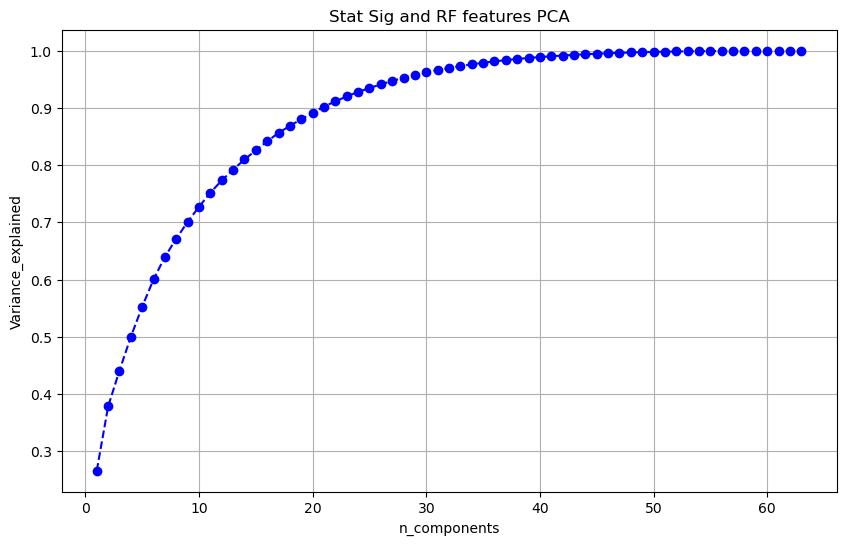

In [24]:
# PCA
n_pca = 40

# Select features for PCA
pca_features = ['age', 'sex'] + sig_vars[:n_pca] + rf_features[:n_pca]
pca_features = list(set(pca_features)) # remove duplicates

print(f'PCA features: {len(pca_features)} - {pca_features}')

# PCA analysis
X_pca, y_pca = PCA_analysis (X_=X_features[pca_features], y_=y, pca_threshold=0.80, title='Stat Sig and RF features PCA').run()

### **7. Data processing**

* 7.1. Removal of nonan
* 7.2. Standarization

#### **7.1. Removal of nonan**

In [25]:
# Remove NaN
X_features_sig_nonnan =    X_features_sig.dropna()
X_features_rf_nonnan =     X_features_rf.dropna()
X_features_sig_rf_nonnan = X_features_sig_rf.dropna()

y_sig =    y[X_features_sig_nonnan.index]
y_rf =     y[X_features_rf_nonnan.index]
y_sig_rf = y[X_features_sig_rf_nonnan.index]

print(X_features_sig_nonnan.shape)
print(y_sig.shape)
print(X_features_rf_nonnan.shape)
print(y_rf.shape)
print(X_features_sig_rf_nonnan.shape)
print(y_sig_rf.shape)

(99, 12)
(99,)
(99, 12)
(99,)
(99, 13)
(99,)


#### **7.2. Standarization**

In [26]:
# Standarization
scaler = StandardScaler()
X_features_sig_scaled =    scaler.fit_transform(X_features_sig_nonnan)
X_features_rf_scaled =     scaler.fit_transform(X_features_rf_nonnan)
X_features_sig_rf_scaled = scaler.fit_transform(X_features_sig_rf_nonnan)

print(X_features_sig_scaled.shape)
print(X_features_rf_scaled.shape)
print(X_features_sig_rf_scaled.shape)

(99, 12)
(99, 12)
(99, 13)


### **8. Supervised Machine Learning - Ensembling Models**

  * 8.1. Extreme Gradient Boosting (XGBoost)
  * 8.2. Light Gradient Boosting Machine (LightGBM)

#### **8.1. Extreme Gradient Boosting (XGBoost)**

In [27]:
# Train XGBoost

def _as_numpy(X, y):
    # Acepta numpy o pandas y devuelve numpy
    if hasattr(X, "values"):
        X = X.values
    if hasattr(y, "values"):
        y = y.values
    return np.asarray(X), np.asarray(y).ravel()


class XGB:

    def __init__(self, X_, y_, param_grid, k, name):
        self.X_, self.y_ = _as_numpy(X_, y_)
        self.param_grid = param_grid
        self.k = k
        self.name = name

    def train_test_stratify_split (self):

        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.2, stratify=self.y_, random_state=0)
    

    def XGB_grid_search(self):

        # Build the model
        xgb = XGBClassifier(objective="binary:logistic", eval_metric="logloss", tree_method="hist", n_jobs=-1, random_state=0)

        # Set the GridSearchCV
        skf = StratifiedKFold(n_splits=self.k, shuffle=True, random_state=0)
        grid_search = GridSearchCV(xgb, self.param_grid, cv=skf, scoring="accuracy", refit=True, verbose=0, n_jobs=-1)

        # Train the model using the GridSearchCV
        grid_search.fit(self.X_train, self.y_train)

        # Save best model
        self.best_params = grid_search.best_params_

        # Show the best hyperparameters
        # print(f'{name} best configuration: {grid_search.best_params_}')


    def XGB_best_params(self):
        
        # Build the model
        self.best_model = XGBClassifier(objective="binary:logistic", eval_metric="logloss",
                                        tree_method="hist", n_jobs=-1, random_state=0, **self.best_params)

        # Train the model with the best config and all trainning data
        self.best_model.fit(self.X_train, self.y_train)
        
        # Evaluate the model
        y_pred = self.best_model.predict(self.X_test)
        test_accuracy = accuracy_score(self.y_test, y_pred)
        test_roc_auc = roc_auc_score(self.y_test, y_pred)
        
        # Computing confidence interval using bootstrapping
        rng = np.random.RandomState(0)
        n_iterations = 1000
        n_size = int(len(self.X_test) * 0.8) # sample_size = 80% sample_size
        accuracy_scores, auc_scores = [], []
    
        for i in range(n_iterations):
            sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)
            
            X_sample = self.X_test[sample_indices,:]
            y_sample = self.y_test[sample_indices]
    
            if len(np.unique(y_sample)) < 2:
                continue
            
            y_pred_sample = self.best_model.predict(X_sample)
            
            accuracy = accuracy_score(y_sample, y_pred_sample)
            accuracy_scores.append(accuracy)
            
            roc_auc = roc_auc_score(y_sample, y_pred_sample)
            auc_scores.append(roc_auc)
    
        # Compute 95% confidence interval
        #accuracy= np.median(score)
        accuracy= test_accuracy
        accuracy_std= np.std(accuracy_scores)
        accuracy_lower = np.percentile(accuracy_scores, 2.5)
        accuracy_upper = np.percentile(accuracy_scores, 97.5)
    
        self.roc_auc= test_roc_auc
        self.roc_auc_std= np.std(auc_scores)
        roc_auc_lower = np.percentile(auc_scores, 2.5)
        roc_auc_upper = np.percentile(auc_scores, 97.5)
    
        # Print results
        print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
        print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


    def run(self):
        print(self.name)
        self.train_test_stratify_split()
        self.XGB_grid_search()
        self.XGB_best_params()
        print("")

In [28]:
# Train Extreme Gradient Boosting
print('XGB')
print('--------------------')

k = 10

# Define param_grid
param_grid_xgb = {'n_estimators':     [100, 300],
                  'learning_rate':    [0.05, 0.1],
                  'max_depth':        [2, 3, 4],
                  'subsample':        [0.8, 1.0],
                  'colsample_bytree': [0.8, 1.0],
                  'reg_lambda':       [1, 5],
                  'min_child_weight': [1, 5]}


# XGB with significant standarized features
XGB (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_xgb, k=k, name='Significant features').run()

# XGB with random forest standarized features
XGB (X_=X_features_rf_scaled,  y_=y_rf,  param_grid=param_grid_xgb, k=k, name='Random forest features').run()

# XGB with Statistical and random forest standarized features
XGB (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=param_grid_xgb, k=k, name='Statistical and Random forest features').run()

# XGB with PCA components
XGB (X_=X_pca, y_=y_pca, param_grid=param_grid_xgb, k=k, name='PCA components').run()

XGB
--------------------
Significant features
Accuracy: 0.70 ± 0.12 [0.44, 0.94]
AUC:      0.70 ± 0.12 [0.46, 0.92]

Random forest features
Accuracy: 0.70 ± 0.11 [0.44, 0.88]
AUC:      0.70 ± 0.12 [0.46, 0.90]

Statistical and Random forest features
Accuracy: 0.75 ± 0.11 [0.56, 0.94]
AUC:      0.75 ± 0.11 [0.52, 0.95]

PCA components
Accuracy: 0.81 ± 0.12 [0.58, 1.00]
AUC:      0.81 ± 0.12 [0.56, 1.00]



#### **8.2. Light Gradient Boosting Machine (LightGBM)**

In [29]:
# Train LightGBM

class LGBM:

    def __init__(self, X_, y_, param_grid, k, name):
        self.X_, self.y_ = _as_numpy(X_, y_)
        self.param_grid = param_grid
        self.k = k
        self.name = name

    def train_test_stratify_split (self):

        # Split the data into training and testing sets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.X_, self.y_, test_size=0.2, stratify=self.y_, random_state=0)
    

    def LGBM_grid_search(self):

        # Build the model
        lgbm = LGBMClassifier(objective="binary", n_jobs=-1, random_state=0, verbose=-1)

        # Set the GridSearchCV
        skf = StratifiedKFold(n_splits=self.k, shuffle=True, random_state=0)
        grid_search = GridSearchCV(lgbm, self.param_grid, cv=skf, scoring="accuracy", refit=True, verbose=0, n_jobs=-1)

        # Train the model using the GridSearchCV
        grid_search.fit(self.X_train, self.y_train)

        # Save best model
        self.best_params = grid_search.best_params_

        # Show the best hyperparameters
        # print(f'{name} best configuration: {grid_search.best_params_}')


    def LGBM_best_params(self):
        
        # Build the model
        self.best_model = LGBMClassifier(objective="binary", n_jobs=-1, random_state=0, verbose=-1, **self.best_params)

        # Train the model with the best config and all trainning data
        self.best_model.fit(self.X_train, self.y_train)
        
        # Evaluate the model
        y_pred = self.best_model.predict(self.X_test)
        test_accuracy = accuracy_score(self.y_test, y_pred)
        test_roc_auc = roc_auc_score(self.y_test, y_pred)
        
        # Computing confidence interval using bootstrapping
        rng = np.random.RandomState(0)
        n_iterations = 1000
        n_size = int(len(self.X_test) * 0.8) # sample_size = 80% sample_size
        accuracy_scores, auc_scores = [], []
    
        for i in range(n_iterations):
            sample_indices = np.random.choice(range(len(self.X_test)), size=n_size, replace=True)
            
            X_sample = self.X_test[sample_indices,:]
            y_sample = self.y_test[sample_indices]
    
            if len(np.unique(y_sample)) < 2:
                continue
            
            y_pred_sample = self.best_model.predict(X_sample)
            
            accuracy = accuracy_score(y_sample, y_pred_sample)
            accuracy_scores.append(accuracy)
            
            roc_auc = roc_auc_score(y_sample, y_pred_sample)
            auc_scores.append(roc_auc)
    
        # Compute 95% confidence interval
        #accuracy= np.median(score)
        accuracy= test_accuracy
        accuracy_std= np.std(accuracy_scores)
        accuracy_lower = np.percentile(accuracy_scores, 2.5)
        accuracy_upper = np.percentile(accuracy_scores, 97.5)
    
        self.roc_auc= test_roc_auc
        self.roc_auc_std= np.std(auc_scores)
        roc_auc_lower = np.percentile(auc_scores, 2.5)
        roc_auc_upper = np.percentile(auc_scores, 97.5)
    
        # Print results
        print(f'Accuracy: {accuracy:.2f} ± {accuracy_std:.2f} [{accuracy_lower:.2f}, {accuracy_upper:.2f}]')
        print(f'AUC:      {self.roc_auc:.2f} ± {self.roc_auc_std:.2f} [{roc_auc_lower:.2f}, {roc_auc_upper:.2f}]')


    def run(self):
        print(self.name)
        self.train_test_stratify_split()
        self.LGBM_grid_search()
        self.LGBM_best_params()
        print("")

In [30]:
# Train Light Gradient Boosting Machine
print('LGBM')
print('--------------------')

k = 10

# Define param_grid
param_grid_lgbm = {'n_estimators':      [100, 300],
                   'learning_rate':     [0.05, 0.1],
                   'max_depth':         [3, 5],
                   'num_leaves':        [7, 15, 31],
                   'subsample':         [0.8, 1.0],
                   'subsample_freq':    [1],
                   'colsample_bytree':  [0.8, 1.0],
                   'reg_lambda':        [0, 1, 5],
                   'min_child_samples': [5, 10, 20]}


# LGBM with significant standarized features
LGBM (X_=X_features_sig_scaled, y_=y_sig, param_grid=param_grid_lgbm, k=k, name='Significant features').run()

# LGBM with random forest standarized features
LGBM (X_=X_features_rf_scaled,  y_=y_rf,  param_grid=param_grid_lgbm, k=k, name='Random forest features').run()

# LGBM with Statistical and random forest standarized features
LGBM (X_=X_features_sig_rf_scaled,  y_=y_sig_rf,  param_grid=param_grid_lgbm, k=k, name='Statistical and Random forest features').run()

# LGBM with PCA components
LGBM (X_=X_pca, y_=y_pca, param_grid=param_grid_lgbm, k=k, name='PCA components').run()

LGBM
--------------------
Significant features
Accuracy: 0.75 ± 0.11 [0.49, 0.94]
AUC:      0.75 ± 0.11 [0.49, 0.94]

Random forest features
Accuracy: 0.70 ± 0.12 [0.45, 0.94]
AUC:      0.70 ± 0.12 [0.45, 0.94]

Statistical and Random forest features
Accuracy: 0.75 ± 0.11 [0.50, 0.94]
AUC:      0.75 ± 0.11 [0.50, 0.94]

PCA components
Accuracy: 0.81 ± 0.12 [0.53, 1.00]
AUC:      0.81 ± 0.12 [0.53, 1.00]

